In [51]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
import torch   
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
#handling text data
from torchtext import data   
import torch.nn as nn
EPOCHS = 30
BATCH_SIZE = 1000
LEARNING_RATE = 0.001
NUM_FEATURES = 1000
NUM_CLASSES = 7
SEED = 2020
#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 



def get_class_distribution(obj):
    count_dict = {
        "0": 0,
        "1": 0,
        "2": 0,
        "3": 0,
        "4": 0,
        "5": 0,
        "6": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['0'] += 1
        elif i == 1: 
            count_dict['1'] += 1
        elif i == 2: 
            count_dict['2'] += 1
        elif i == 3: 
            count_dict['3'] += 1
        elif i == 4: 
            count_dict['4'] += 1  
        elif i == 5: 
            count_dict['5'] += 1    
        elif i == 6:
            count_dict['6'] += 1
        else:
            print("Check classes.")
            
    return count_dict

In [2]:
df = pd.read_csv('data/preprocessed_case_study_data.csv')
with open('data/val_indices.pickle', 'rb') as f:
    val_ind = pickle.load(f)

In [3]:
with open('data/label_mapping.pickle', 'rb') as f:
    map_dct = pickle.load(f)

In [4]:
train = df.loc[~df.complaint_id.isin(val_ind)]
val = df.loc[df.complaint_id.isin(val_ind)]

In [5]:
#vectorizer = CountVectorizer(max_features=1000)
#vectorizer.fit(train.prep_text.tolist())

In [6]:
#with open('models/shallow_network/count_vect_1000.pickle', 'wb') as f:
#    pickle.dump(vectorizer, f)
#f.close()

In [7]:
#vectorizer.get_feature_names()

In [8]:
#df.head()

In [9]:
#train.to_csv('data/train.csv', index = False)
#val.to_csv('data/val.csv', index = False)

In [10]:
class CountsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_csv = 'data/train.csv', vectorizer_file = 'count_vect_1000.pickle', root_dir = 'models/shallow_network/', transform=None):
        """
       
        """
        with open('models/shallow_network/count_vect_1000.pickle', 'rb') as f:
            self.vectorizer = pickle.load(f)
        self.data = pd.read_csv(data_csv)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        text = self.data.loc[idx, 'prep_text']
        x = self.vectorizer.transform([text])
        sample = (x.todense(), [self.data.loc[idx,'label']])

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        x, label = sample[0], sample[1]

        return (torch.FloatTensor(x), torch.LongTensor(label))

In [12]:
transformed_dataset = CountsDataset(data_csv='data/train.csv', transform = ToTensor())
                                          

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample[0].size(), sample[1].size())
    if i == 3:
        break

0 torch.Size([1, 1000]) torch.Size([1])
1 torch.Size([1, 1000]) torch.Size([1])
2 torch.Size([1, 1000]) torch.Size([1])
3 torch.Size([1, 1000]) torch.Size([1])


In [13]:
transformed_dataset_val = CountsDataset(data_csv='data/val.csv', transform = ToTensor())
                                          

#for i in range(len(transformed_dataset_val)):
#    sample = transformed_dataset_val[i]#

#    print(i, sample[0].size(), sample[1].size())
 #   if i == 3:
 #       break

In [14]:
target_list = []
for i in range(len(transformed_dataset)):
    target_list.append(transformed_dataset[i][1])
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [15]:
y_train = np.array(train.label)
y_val = np.array(val.label)
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([5.5359e-05, 3.7597e-05, 1.3679e-05, 1.8080e-05, 3.5803e-05, 2.3469e-04,
        2.7585e-05])


In [16]:
class_weights_all = class_weights[target_list]

In [17]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [19]:
train_loader = DataLoader(dataset=transformed_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=transformed_dataset_val, batch_size=1)


In [20]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [23]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [24]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [25]:
print("Begin training.")
best_valid_loss = float('inf')
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch.squeeze())
        #print(y_train_pred.size())
        #print(y_train_batch.size())
        train_loss = criterion(y_train_pred, y_train_batch.squeeze())
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch.squeeze(dim = 1))
            #print(y_val_pred.size())
            #print(y_val_batch.size())
            val_loss = criterion(y_val_pred, y_val_batch.squeeze(1))
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    if val_epoch_loss/len(val_loader) < best_valid_loss:
        best_valid_loss = val_epoch_loss/len(val_loader)
        torch.save(model.state_dict(), 'models/shallow_network/saved_weights.pt')
        
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  0%|          | 0/30 [00:00<?, ?it/s]

Begin training.


  3%|▎         | 1/30 [01:39<47:56, 99.20s/it]

Epoch 001: | Train Loss: 0.65079 | Val Loss: 0.54521 | Train Acc: 18844.215| Val Acc: 82.043


  7%|▋         | 2/30 [03:17<46:12, 99.02s/it]

Epoch 002: | Train Loss: 0.44716 | Val Loss: 0.53566 | Train Acc: 19180.165| Val Acc: 82.520


 10%|█         | 3/30 [04:56<44:32, 98.99s/it]

Epoch 003: | Train Loss: 0.39592 | Val Loss: 0.52579 | Train Acc: 19295.868| Val Acc: 82.933


 13%|█▎        | 4/30 [06:36<42:58, 99.16s/it]

Epoch 004: | Train Loss: 0.34222 | Val Loss: 0.50877 | Train Acc: 19314.876| Val Acc: 83.828


 17%|█▋        | 5/30 [08:15<41:18, 99.13s/it]

Epoch 005: | Train Loss: 0.30911 | Val Loss: 0.52804 | Train Acc: 19296.694| Val Acc: 83.515


 20%|██        | 6/30 [09:54<39:41, 99.21s/it]

Epoch 006: | Train Loss: 0.26870 | Val Loss: 0.52263 | Train Acc: 19416.529| Val Acc: 83.761


 23%|██▎       | 7/30 [11:33<37:59, 99.11s/it]

Epoch 007: | Train Loss: 0.24252 | Val Loss: 0.54540 | Train Acc: 19487.603| Val Acc: 83.597


 27%|██▋       | 8/30 [13:12<36:19, 99.08s/it]

Epoch 008: | Train Loss: 0.21920 | Val Loss: 0.58477 | Train Acc: 19474.793| Val Acc: 83.038


 30%|███       | 9/30 [14:52<34:46, 99.37s/it]

Epoch 009: | Train Loss: 0.20129 | Val Loss: 0.57659 | Train Acc: 19547.107| Val Acc: 83.660


 33%|███▎      | 10/30 [16:31<33:06, 99.35s/it]

Epoch 010: | Train Loss: 0.18209 | Val Loss: 0.60048 | Train Acc: 19519.835| Val Acc: 83.157


 37%|███▋      | 11/30 [18:12<31:31, 99.58s/it]

Epoch 011: | Train Loss: 0.16841 | Val Loss: 0.61098 | Train Acc: 19537.603| Val Acc: 84.003


 40%|████      | 12/30 [19:52<29:54, 99.70s/it]

Epoch 012: | Train Loss: 0.15326 | Val Loss: 0.62709 | Train Acc: 19612.397| Val Acc: 83.451


 43%|████▎     | 13/30 [21:31<28:15, 99.71s/it]

Epoch 013: | Train Loss: 0.14237 | Val Loss: 0.65031 | Train Acc: 19619.008| Val Acc: 83.567


 47%|████▋     | 14/30 [23:11<26:36, 99.77s/it]

Epoch 014: | Train Loss: 0.13502 | Val Loss: 0.64109 | Train Acc: 19665.289| Val Acc: 83.489


 50%|█████     | 15/30 [24:51<24:54, 99.66s/it]

Epoch 015: | Train Loss: 0.12319 | Val Loss: 0.67029 | Train Acc: 19617.355| Val Acc: 83.720


 53%|█████▎    | 16/30 [26:30<23:15, 99.68s/it]

Epoch 016: | Train Loss: 0.11838 | Val Loss: 0.69312 | Train Acc: 19676.446| Val Acc: 83.559


 57%|█████▋    | 17/30 [28:11<21:40, 100.03s/it]

Epoch 017: | Train Loss: 0.10949 | Val Loss: 0.70349 | Train Acc: 19703.306| Val Acc: 83.537


 60%|██████    | 18/30 [29:52<20:03, 100.31s/it]

Epoch 018: | Train Loss: 0.10653 | Val Loss: 0.71973 | Train Acc: 19711.983| Val Acc: 83.578


 63%|██████▎   | 19/30 [31:32<18:22, 100.23s/it]

Epoch 019: | Train Loss: 0.10396 | Val Loss: 0.71878 | Train Acc: 19632.231| Val Acc: 83.813


 67%|██████▋   | 20/30 [33:12<16:42, 100.22s/it]

Epoch 020: | Train Loss: 0.09423 | Val Loss: 0.74114 | Train Acc: 19704.545| Val Acc: 83.787


 70%|███████   | 21/30 [34:53<15:01, 100.22s/it]

Epoch 021: | Train Loss: 0.08639 | Val Loss: 0.75532 | Train Acc: 19754.959| Val Acc: 83.764


 73%|███████▎  | 22/30 [36:32<13:19, 99.90s/it] 

Epoch 022: | Train Loss: 0.08542 | Val Loss: 0.77464 | Train Acc: 19693.388| Val Acc: 83.835


 77%|███████▋  | 23/30 [38:11<11:38, 99.83s/it]

Epoch 023: | Train Loss: 0.08144 | Val Loss: 0.78518 | Train Acc: 19730.579| Val Acc: 83.828


 80%|████████  | 24/30 [39:51<09:57, 99.66s/it]

Epoch 024: | Train Loss: 0.07913 | Val Loss: 0.80444 | Train Acc: 19737.603| Val Acc: 83.776


 83%|████████▎ | 25/30 [41:30<08:17, 99.48s/it]

Epoch 025: | Train Loss: 0.07457 | Val Loss: 0.79953 | Train Acc: 19736.777| Val Acc: 83.906


 87%|████████▋ | 26/30 [43:09<06:37, 99.46s/it]

Epoch 026: | Train Loss: 0.07391 | Val Loss: 0.81123 | Train Acc: 19715.289| Val Acc: 83.835


 90%|█████████ | 27/30 [44:48<04:58, 99.37s/it]

Epoch 027: | Train Loss: 0.06983 | Val Loss: 0.83833 | Train Acc: 19736.364| Val Acc: 83.798


 93%|█████████▎| 28/30 [46:28<03:18, 99.47s/it]

Epoch 028: | Train Loss: 0.07004 | Val Loss: 0.84344 | Train Acc: 19779.752| Val Acc: 83.444


 97%|█████████▋| 29/30 [48:08<01:39, 99.61s/it]

Epoch 029: | Train Loss: 0.06909 | Val Loss: 0.84899 | Train Acc: 19709.504| Val Acc: 83.891


100%|██████████| 30/30 [49:47<00:00, 99.59s/it]

Epoch 030: | Train Loss: 0.06213 | Val Loss: 0.85688 | Train Acc: 19723.554| Val Acc: 83.846


In [34]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        #print(X_batch.size())
        y_test_pred = model(X_batch.squeeze(1))
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [38]:
y_test = np.array(val.label)

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
print('Shallow NN base:')
print(classification_report(y_test, y_pred_list, target_names = map_dct.keys()))

Shallow NN base:
                  precision    recall  f1-score   support

    bank_service       0.74      0.80      0.77      2007
     credit_card       0.80      0.75      0.78      2955
credit_reporting       0.87      0.89      0.88      8123
 debt_collection       0.84      0.81      0.82      6146
            loan       0.79      0.77      0.78      3104
 money_transfers       0.70      0.75      0.72       473
        mortgage       0.90      0.93      0.92      4028

        accuracy                           0.84     26836
       macro avg       0.81      0.81      0.81     26836
    weighted avg       0.84      0.84      0.84     26836



[[1610  140   39   40   36   87   55]
 [ 234 2221  203  167   67   38   25]
 [  48  160 7231  414  166    5   99]
 [  79  122  567 4979  285    7  107]
 [  69   86  193  266 2376   12  102]
 [  72   23    7    6    6  354    5]
 [  54   23   78   54   84    5 3730]]


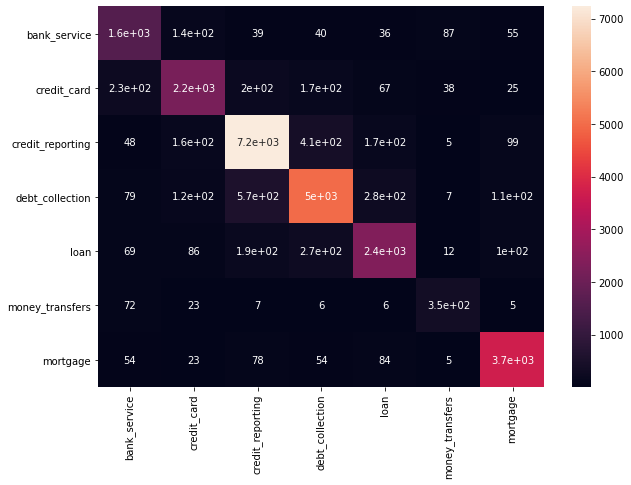

In [44]:
import seaborn as sn
cm = confusion_matrix(y_test, y_pred_list)
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in map_dct.keys()],
                  columns = [i for i in map_dct.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 588,295 trainable parameters
